<a href="https://colab.research.google.com/github/eduion/computer_vision/blob/main/calorie_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image

from google.colab import files
import io

In [5]:
IMG_SIZE = 224   # 訓練 MobileNetV2 用的圖片大小

model_path = "/content/mobilenetv2_food101_finetune_best.h5"

model = load_model(model_path, compile=False)
print("模型載入完成")

模型載入完成


In [7]:
classes_txt_path = "/content/classes.txt"
with open(classes_txt_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]

idx_to_class = {i: name for i, name in enumerate(class_names)}
nutri_path = "/content/nutrition_food101.csv"
nutri_df = pd.read_csv(nutri_path)

In [8]:
nutri_table = {
    row["food101_class"]: row
    for _, row in nutri_df.iterrows()
}

def lookup_nutrition(food101_class):
    row = nutri_table.get(food101_class)
    if row is None:
        return None, None
    kcal = row.get("kcal", None)
    protein = row.get("protein_g", None)
    return kcal, protein

In [11]:
def predict_and_show(img_pil):
    # 顯示原圖
    plt.figure(figsize=(4,4))
    plt.imshow(img_pil)
    plt.axis("off")
    plt.title("upload picture")
    plt.show()

    # resize + 正規化
    img_resized = img_pil.resize((IMG_SIZE, IMG_SIZE))
    img_arr = np.array(img_resized).astype("float32") / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)  # (1, H, W, 3)

    # 模型預測
    preds = model.predict(img_arr)
    probs = preds[0]
    pred_idx = int(np.argmax(probs))
    pred_prob = float(probs[pred_idx])
    food_class = idx_to_class[pred_idx]   # e.g. "apple_pie"

    # 查營養表
    kcal, protein = lookup_nutrition(food_class)

    # 輸出結果
    print("=== predict result ===")
    print(f"Food-101 class：{food_class}")
    print(f"置信度：{pred_prob*100:.2f} %")

    print("\n=== 營養資訊（每份/每100g） ===")
    if kcal is not None:
        print(f"熱量：{kcal} kcal")
    else:
        print("熱量：無資料")

    if protein is not None:
        print(f"蛋白質：{protein} g")
    else:
        print("蛋白質：無資料")


Saving fried_ice.jpg to fried_ice.jpg
upload picture： fried_ice.jpg


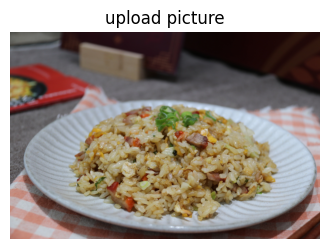

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
=== predict result ===
Food-101 class：fried_rice
置信度：99.89 %

=== 營養資訊（每份/每100g） ===
熱量：183.0 kcal
蛋白質：3.33 g


In [16]:
uploaded = files.upload()  # 會跳出選檔視窗

for filename, data in uploaded.items():
    print("upload picture：", filename)

    # 用 Bytes 讀成 PIL Image
    img_pil = Image.open(io.BytesIO(data)).convert("RGB")

    predict_and_show(img_pil)
